In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline
sns.set(color_codes=True)

# Introduction

<p>The rise of online rating systems has had a major impact on the film industry, as on many others.  Critic and fan ratings are aggregated on popular websites like Metacritic and Rotten Tomatoes, where consumers can view both numbers to inform their decision-making.  In the early stages of a film's release, these ratings may affect consumer choices to a significant degree; once the box office run is complete, they serve as good indicators of a film's popular and critical reception, and, to some extent, as proxies for its artistic quality. </p>

<p>While the critical and popular ratings generally tend to correlate, there are well-known discrepancies between them.  The tastes of popular audiences and of critics differ, and as in most artistic fields, the nature and merit of those differences are debated.</p>

<p>This report examines ratings data on 225 films - fifteen films from every year from 2002 through 2016.  The data, pulled from Kaggle.com, was originally scraped from the International Movie Database (IMDb), Metacritic, and Rotten Tomatoes (RT).  It includes aggregated critic and fan ratings, as well as genre tags and basic data such as budget, year, and box office revenue.  Using this data, I will address questions like: </p>
<ul>
    <li>How much do fans and critics disagree, and on what sorts of movies?</li>
    <li>Do critical reviews, popular reviews, or some other factor better predict box office revenue?</li>
    <li>Are these patterns steady across the past fifteen years?</li>
    <li>Are there outlier films that defy these trends?</li>
</ul>

# Loading the data
<p>First we have to pull the ratings data from the primary dataset, moviesData.csv, and combine it with more extensive basic data from a larger but rating-less IMDb dataset (movies_basic_metadata.csv).

In [15]:
# upload and merge datasets
movies_df = pd.read_csv("moviesData.csv")
movies_basic_metadata_df = pd.read_csv("movies_basic_metadata.csv")
movies_df = movies_df.merge(movies_basic_metadata_df.drop_duplicates("title"), how="inner", left_on="Titles", right_on="title")

# tweak titles and scaling for ease of use
movies_df.rename(columns = {"Titles":"Title"}, inplace=True)
# rescale IMDb fan rating to match other aggregated ratings, which are out of 100
movies_df["IMDb"] *= 10
# convert budget to int (it's stored as a string for some reason)
movies_df.budget = movies_df.budget.astype(int)

# convert budget and BoxOffice to 2016 USD using data from usinflationalcalculator.com
inflation_dict = {2002:1.33, 2003:1.30 , 2004:1.26 , 2005:1.22 , 2006:1.19 , 2007:1.15 , 2008:1.11 , 2009:1.11 ,
              2010:1.10 , 2011:1.06 , 2012:1.04 , 2013:1.03 , 2014:1.01 , 2015:1.01, 2016:1.0 }
movies_df["budget"] = [inflation_dict[movies_df["Year"][i]] * movies_df["budget"][i] for i in range(len(movies_df))]
movies_df["BoxOffice"] = [inflation_dict[movies_df["Year"][i]] * movies_df["BoxOffice"][i] for i in range(len(movies_df))]
# convert budget and BoxOffice to millions
movies_df["budget"] /= 10**6
movies_df["BoxOffice"] /= 10**6

# create a composite fan rating column from the two fan ratings columns
movies_df["allFans"] = (movies_df["IMDb"] + movies_df["RTFan"])/2
# create a composite critic rating column from the two critic ratings columns
movies_df["allCritics"] = (movies_df["RTCritic"] + movies_df["Metacritic"])/2

movies_df.head()

,Title,Rating,RTCritic,RTFan,IMDb,Metacritic,BoxOffice,Year,Action,Animation,...,production_companies,release_date,revenue,runtime,status,tagline,vote_average,vote_count,allFans,allCritics
0,Treasure Planet,PG,69,70,71.0,60,50.700337,2002,1,1,...,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",2002-11-26,109578115.0,95.0,Released,Find your place in the universe.,7.2,980.0,70.5,64.5
1,About Schmidt,R,85,74,72.0,85,86.456939,2002,0,0,...,"[{'name': 'New Line Cinema', 'id': 12}, {'name...",2002-12-13,105834556.0,125.0,Released,Schmidt Happens,6.7,365.0,73.0,85.0
2,Secretary,R,76,82,70.0,63,5.382160,2002,0,0,...,"[{'name': 'Slough Pond', 'id': 4730}, {'name':...",2002-01-11,9304609.0,104.0,Released,Assume the position.,6.8,378.0,76.0,69.5
3,Irreversible,NR,57,80,74.0,51,1.053626,2002,0,0,...,"[{'name': 'Eskwad', 'id': 616}, {'name': 'Stud...",2002-05-22,792.0,97.0,Released,Time destroys everything.,7.1,550.0,77.0,54.0
4,Big Trouble,PG13,48,54,65.0,47,9.658843,2002,0,0,...,"[{'name': 'Touchstone Pictures', 'id': 9195}]",2002-04-05,8493890.0,85.0,Released,They have forty-five minutes to save the world...,6.3,82.0,59.5,47.5


# Movies at a glance
<p>The movies in this 15-year dataset are spread unevenly across genres, with Drama leading the way at 105, and Horror coming in last at just 18.  The genre tags are non-exclusive (a movie can be both Romance and Drama), so the genre counts add up to more than the total number of films in the dataset.</p>

In [16]:
genre_ratings = []
# there's only one documentary, and it's a mislabel (no, "Ice Age: The Meltdown" is not a documentary)
del movies_df["Documentary"]
# remove international, since there's also only one
del movies_df["International"]

genre_titles = list(movies_df)[10:17]
# compile counts, along with fan and critic rating means, associated with each genre
for genre_title in genre_titles:
    genre_ratings.extend( [
        genre_title,
        len(movies_df[movies_df[genre_title]==1]),
        movies_df[movies_df[genre_title]==1]["allFans"].mean(),
        movies_df[movies_df[genre_title]==1]["allCritics"].mean()
        ])
# reshape this list into a dataframe
genre_df = pd.DataFrame(np.array(genre_ratings).reshape(7,4), columns = ["genre","count", "allFans", "allCritics"])

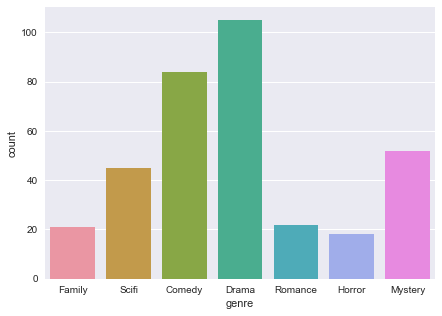

In [4]:
# graph the genre distribution
plt.figure(figsize=(7,5))
# it's unclear why "count" column needs to be retyped, but sns throws an error without it
genre_df["count"] = genre_df["count"].astype(int)
sns.barplot(x="genre", y="count", data=genre_df)
plt.show()

<p>The median budget of the films is \$27 million USD, while the median box office revenue is \$42 million.  The distributions of both budget and box office revenue cluster toward the left, with a small number of high-budget, high-revenue films trailing out to the right, roughly following a reciprocal function curve.  Neither budgets nor box office revenues showed any significant change across the 15 years included in the data.</p>

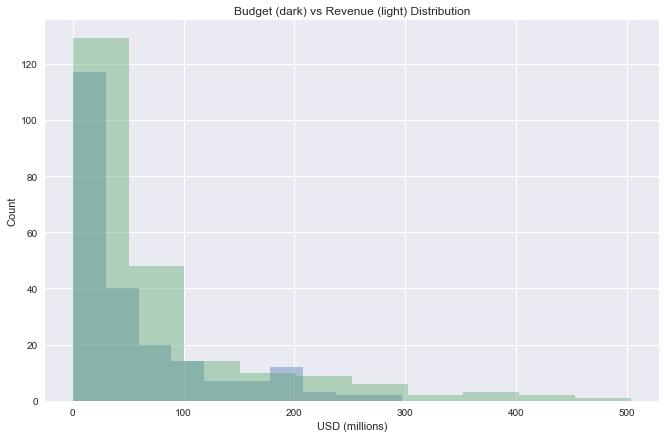

In [5]:
plt.figure(figsize=(11,7))
# plt.subplot(1,2,1)
plt.hist(movies_df["budget"], alpha=0.4)

# plt.subplot(1,2,2)
plt.hist(movies_df["BoxOffice"], alpha=0.4)
plt.xlabel('USD (millions)')
plt.ylabel('Count')
plt.title('Budget (dark) vs Revenue (light) Distribution')
plt.show()

# Ratings at a glance

<p>As we can see below, there are some significant differences in the distributions of the different ratings.  To begin with, the means of both fan ratings (Rotten Tomatoes(RT) fans and IMDb fans) are significantly higher than the mean of either critic rating mean.  The mean of the combined fan ratings (Rotten Tomatoes and IMDb) is 61.6, nearly nine percentage points higher than the mean of the combined critic ratings (52.1).</p>

<p>There are several possible explanations (not necessarily exclusive) for this difference in mean ratings from fans vs. critics.  The first is selection bias: fans mostly watch only those movies they expect to enjoy, whereas reviewers, as paid professionals, will watch movies for the purpose of reviewing that they would not watch for pleasure.  Second, fans may have a genuinely more enjoyable experience watching an average movie, since they are typically watching purely for recreation and not for work.  And third, critics are likely to make a greater conscious effort than fans to calibrate their ratings to the mean.</p>

<p>Aside from the difference of mean, it is also noteworthy that IMDb fan scores have the narrowest distribution (highly concentrated around a mean of 64), whereas the distribution of Rotten Tomatoes aggregated critical scores is nearly uniform.</p>

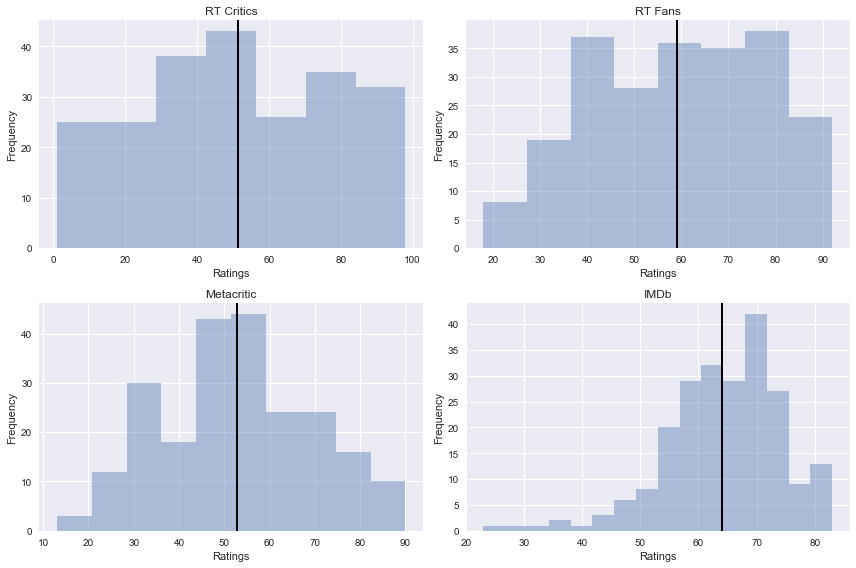

In [7]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.distplot(movies_df['RTCritic'], label="RT Critic", kde=False)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('RT Critics')
plt.axvline(movies_df["RTCritic"].mean(), color='black', linewidth=2)

plt.subplot(2,2,2)
sns.distplot(movies_df['RTFan'], label="RT Fan", kde=False)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('RT Fans')
plt.axvline(movies_df["RTFan"].mean(), color='black', linewidth=2)

plt.subplot(2,2,3)
sns.distplot(movies_df['Metacritic'], label="Metacritic", kde=False)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Metacritic')
plt.axvline(movies_df["Metacritic"].mean(), color='black', linewidth=2)

plt.subplot(2,2,4)
sns.distplot(movies_df['IMDb'], label="IMDb fans", kde=False)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('IMDb')
plt.axvline(movies_df["IMDb"].mean(), color='black', linewidth=2)
plt.tight_layout()
plt.show()

# Differences between fan and critic ratings

<p>While fan and critic ratings are by no means in lockstep, they do have a moderate-to-strong correlation (r=0.77).</p>

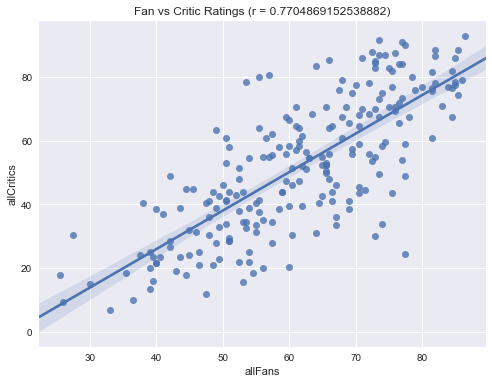

In [8]:
plt.figure(figsize=(8,6))
x = movies_df["allFans"]
y = movies_df["allCritics"]
sns.regplot(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Fan vs Critic Ratings (r = {})".format(r));

It is worth noting that the correlations between the two fan groups (Rotten Tomatoes and IMDb) is not perfect either (r = 0.82).  The correlation between Rotten Tomato and Metacritic ratings is significantly closer (r = 0.93).  The latter correlation is unsurprising: although the two sites use different weightings in their aggregation algorithms, the actual critics used by Metacritic are almost entirely a subset of the broader selection included by Rotten Tomatoes.

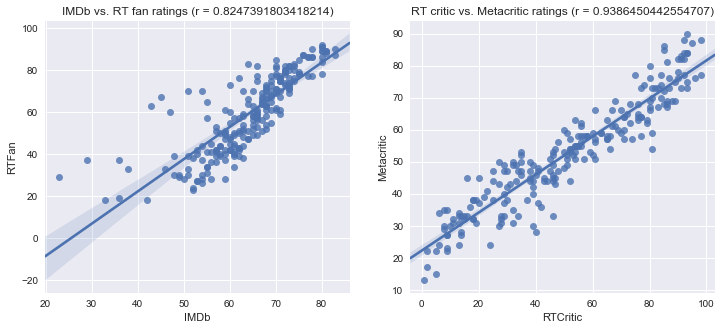

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
x = movies_df["IMDb"]
y = movies_df["RTFan"]
sns.regplot(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("IMDb vs. RT fan ratings (r = {})".format(r))

plt.subplot(1,2,2)
x = movies_df["RTCritic"]
y = movies_df["Metacritic"]
sns.regplot(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RT critic vs. Metacritic ratings (r = {})".format(r));

The differences between fan and critic ratings do show pronounced differences by genre.  

In [12]:
genre_df.head()

,Unnamed: 0,genre,count,allFans,allCritics
0,0,Family,21,63.142857,58.523810
1,1,Scifi,45,60.488889,49.277778
2,2,Comedy,84,58.577381,49.059524
3,3,Drama,105,64.638095,56.004762
4,4,Romance,22,62.454545,47.636364


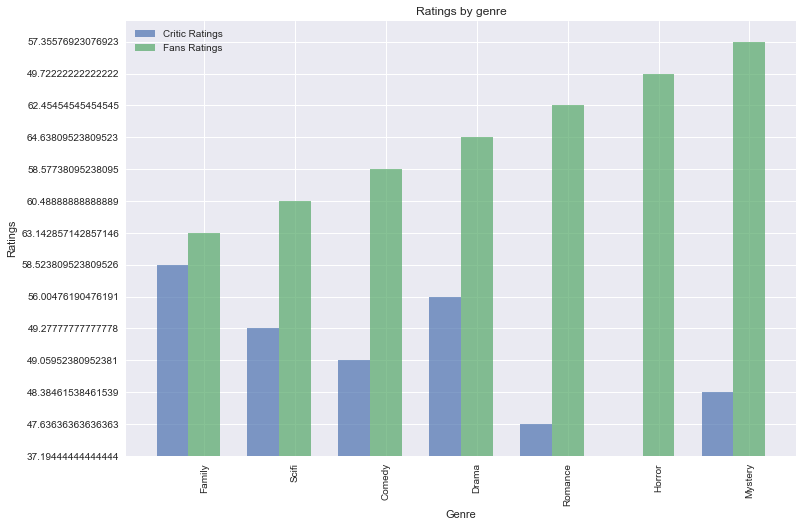

In [17]:
plt.figure(figsize=(12,8))

n_groups = 7
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.7

rects1 = plt.bar(index, genre_df["allCritics"], bar_width,
                 alpha=opacity,
                 color='b',
                 label="Critic Ratings")
 
rects2 = plt.bar(index + bar_width, genre_df["allFans"], bar_width,
                 alpha=opacity,
                 color='g',
                 label="Fans Ratings")
plt.xlabel('Genre')
plt.ylabel('Ratings')
plt.title('Ratings by genre')
plt.xticks(index + bar_width, genre_df["genre"], rotation=90)
plt.set_ylim=(0,70)

plt.legend()
 
plt.show()

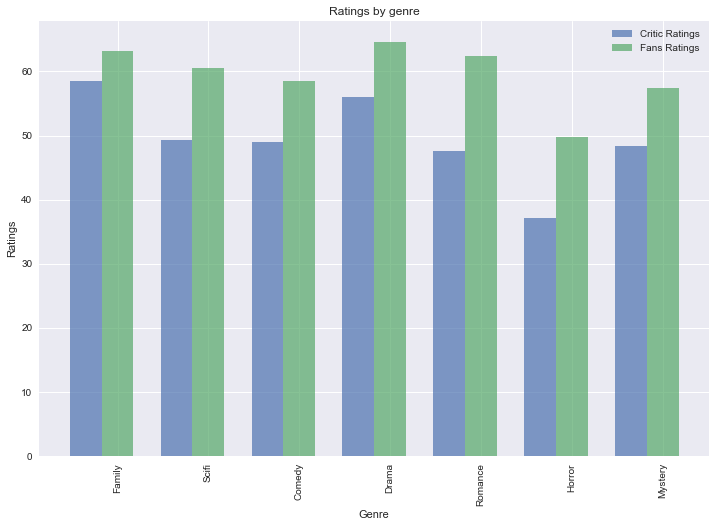

In [11]:
fig = plt.figure(figsize=(12,8))
genre_df = pd.read_csv("genres.csv")
n_groups = 7
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.7

rects1 = plt.bar(index, genre_df["allCritics"], bar_width,
                 alpha=opacity,
                 color='b',
                 label="Critic Ratings")
 
rects2 = plt.bar(index + bar_width, genre_df["allFans"], bar_width,
                 alpha=opacity,
                 color='g',
                 label="Fans Ratings")
plt.xlabel('Genre')
plt.ylabel('Ratings')
plt.title('Ratings by genre')
plt.xticks(index + bar_width, genre_df["genre"], rotation=90)
fig.ylim=(0,70)

plt.legend()
 
plt.show()

In [ ]:
plt.yticks(np.arange(80))  - why doesn't this work

In [ ]:
movies_df[movies_df["Scifi"]==1].head()

x = movies_df[movies_df["Scifi"]==1]["Year"]
y = movies_df[movies_df["Scifi"]==1]["allCritics"]
plt.scatter(x,y)
plt.show()

In [ ]:
ax = sns.barplot(x="Genre", y="allCritics", hue="bechdel", data=movies_df)
plt.show()

In [ ]:
print(movies_df["RTCritic"].mean())
print(movies_df["RTFan"].mean())
print(movies_df["RTCritic"].std())
print(movies_df["RTFan"].std())
print(movies_df["Metacritic"].mean())
print(movies_df["Metacritic"].std())
print(movies_df["IMDb"].mean()*10)

In [ ]:
#count of category occurence in data
movies_df.Rating.value_counts().plot(kind = "bar")
plt.xlabel('Movie Rating')
plt.ylabel('Count')
plt.title('Movie Rating Count');

# Money

# Ratings as predictors of box office revenues

In [ ]:
print(type(movies_df["BoxOffice"][12]))
print(type(movies_df["revenue"][12]))
print(type(movies_df["budget"][12]))

In [ ]:
x = movies_df["budget"]
y = movies_df["revenue"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Budget vs Revenue (r = {})".format(r))
plt.show()

x = movies_df["BoxOffice"]
y = movies_df["revenue"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Box Office vs Revenue (r = {})".format(r))
plt.show()


In [ ]:
print("bechdel-passing mean box office: {}".format( movies_df[movies_df["bechdel"]=="PASS"]["BoxOffice"].mean() ))
print("bechdel-failing mean box office: {}".format( movies_df[movies_df["bechdel"]=="FAIL"]["BoxOffice"].mean() ))

x = movies_df[movies_df["bechdel"]=="PASS"]["Year"]
y = movies_df[movies_df["bechdel"]=="PASS"]["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Bechdel-passing year vs box-office (r = {})".format(r))
plt.show()

x = movies_df[movies_df["bechdel"]=="FAIL"]["Year"]
y = movies_df[movies_df["bechdel"]=="FAIL"]["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Bechdel-failing year vs box-office (r = {})".format(r))
plt.show()

# Critical vs Popular Ratings

In [ ]:
x = movies_df["RTCritic"]
y = movies_df["RTFan"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RT Critic vs RT fan (r = {})".format(r))
plt.show()

x = movies_df["Metacritic"]
y = movies_df["IMDb"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Metacritic vs IMDb (r = {})".format(r))
plt.show()

x = movies_df["RTFan"]
y = movies_df["IMDb"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RTFan vs IMDb (r = {})".format(r))
plt.show()

x = movies_df["RTCritic"]
y = movies_df["Metacritic"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RTCritic vs Metacritic (r = {})".format(r))
plt.show()


# Ratings as predictors of box office revenue

In [ ]:
x = movies_df["RTCritic"]
y = movies_df["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RT Critic vs revenue (r = {})".format(r))
plt.show()

x = movies_df["RTFan"]
y = movies_df["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RT Fan vs revenue (r = {})".format(r))
plt.show()

x = movies_df["Metacritic"]
y = movies_df["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Metacritic vs revenue (r = {})".format(r))
plt.show()

x = movies_df["IMDb"]
y = movies_df["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("IMDb vs revenue (r = {})".format(r))
plt.show()


# Possible Factors in Critical-vs-Popular rating discrepancies

In [ ]:
movies_df["allFans"] = (movies_df["IMDb"] + movies_df["RTFan"])/2
movies_df["allCritics"] = (movies_df["RTCritic"] + movies_df["Metacritic"])/2
movies_df["discrepancy"] = movies_df["allFans"] - movies_df["allCritics"]
movies_df["normDiscrepancy"] = (movies_df["allFans"]-movies_df["allFans"].mean()) \
                                - (movies_df["allCritics"]-movies_df["allCritics"].mean())

plt.scatter(movies_df['allCritics'], movies_df["allFans"])
plt.xlabel('Critical ratings')
plt.ylabel('Fan ratings')
plt.title("critical vs fan ratings")
plt.show()

plt.hist(movies_df['discrepancy'], alpha=0.5)
plt.xlabel('Discrepancy')
plt.ylabel('Frequency')
plt.title('rating discrepancies')
plt.axvline(movies_df["RTCritic"].mean(), color='black', linewidth=2)
plt.show()

plt.hist(movies_df['normDiscrepancy'], alpha=0.5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title("normalized rating discrepancies")
plt.axvline(movies_df["RTCritic"].mean(), color='black', linewidth=2)
plt.show()

plt.scatter(movies_df['normDiscrepancy'], movies_df["BoxOffice"])
plt.xlabel('normed discrepancy')
plt.ylabel('box office revenue')
plt.title("normed discrepancy vs revenue")
plt.show()


# Year effects
basically, there aren't any
# chart bechdel-hued budget vs year and revenue vs year!!!

In [ ]:
x = movies_df["Year"]
y = movies_df["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Year vs Revenue (r = {})".format(r))
plt.show()

x = movies_df["Year"]
y = movies_df["IMDb"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Year vs IMDb (r = {})".format(r))
plt.show()

x = movies_df["Year"]
y = movies_df["allCritics"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Year vs allCritics (r = {})".format(r))
plt.show()

x = movies_df["Year"]
y = movies_df["allFans"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Year vs allFans (r = {})".format(r))
plt.show()


In [ ]:
g = sns.FacetGrid(movies_df, col="Rating",  row="BoxOffice")
g = g.map(plt.scatter, "allFans", "allCritics")
plt.show()